In [55]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from tqdm import tqdm
import dill
import sys

In [56]:
# Import the environment and plotting functions
sys.path.insert(0,'./env')
sys.path.insert(0,'./utils')
from env.food_collector import Food_Collector_Env
from utils.plot_results import plot_scores_epsilon

# VDN

## Define VDN architecture

In [57]:
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [58]:
class ReplayBuffer:
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample_chunk(self, batch_size, chunk_size):
        start_idx = np.random.randint(0, len(self.buffer) - chunk_size, batch_size)
        s_lst, a_lst, r_lst, s_prime_lst, done_lst = [], [], [], [], []

        for idx in start_idx:
            for chunk_step in range(idx, idx + chunk_size):
                s, a, r, s_prime, done = self.buffer[chunk_step]
                s_lst.append(s)
                a_lst.append(a)
                r_lst.append(r)
                s_prime_lst.append(s_prime)
                done_lst.append(done)

        n_agents, obs_size = len(s_lst[0]), len(s_lst[0][0])
        return torch.tensor(s_lst, dtype=torch.float).view(batch_size, chunk_size, n_agents, obs_size), \
               torch.tensor(a_lst, dtype=torch.float).view(batch_size, chunk_size, n_agents), \
               torch.tensor(r_lst, dtype=torch.float).view(batch_size, chunk_size, n_agents), \
               torch.tensor(s_prime_lst, dtype=torch.float).view(batch_size, chunk_size, n_agents, obs_size), \
               torch.tensor(done_lst, dtype=torch.float).view(batch_size, chunk_size, 1)

    def size(self):
        return len(self.buffer)


In [60]:
class QNet(nn.Module):
    def __init__(self, observation_space, action_space, recurrent=False):
        super(QNet, self).__init__()
        self.num_agents = len(observation_space)
        self.recurrent = recurrent
        self.hx_size = 32
        for agent_i in range(self.num_agents):
            n_obs = observation_space[agent_i].shape[0]
            setattr(self, 'agent_feature_{}'.format(agent_i), nn.Sequential(nn.Linear(n_obs, 64),
                                                                            nn.ReLU(),
                                                                            nn.Linear(64, self.hx_size),
                                                                            nn.ReLU()))
            if recurrent:
                setattr(self, 'agent_gru_{}'.format(agent_i), nn.GRUCell(self.hx_size, self.hx_size))
            setattr(self, 'agent_q_{}'.format(agent_i), nn.Linear(self.hx_size, action_space[agent_i].n))

    def forward(self, obs, hidden):
        q_values = [torch.empty(obs.shape[0], )] * self.num_agents
        next_hidden = [torch.empty(obs.shape[0], 1, self.hx_size)] * self.num_agents
        for agent_i in range(self.num_agents):
            x = getattr(self, 'agent_feature_{}'.format(agent_i))(obs[:, agent_i, :])
            if self.recurrent:
                x = getattr(self, 'agent_gru_{}'.format(agent_i))(x, hidden[:, agent_i, :])
                next_hidden[agent_i] = x.unsqueeze(1)
            q_values[agent_i] = getattr(self, 'agent_q_{}'.format(agent_i))(x).unsqueeze(1)

        return torch.cat(q_values, dim=1), torch.cat(next_hidden, dim=1)

    def sample_action(self, obs, hidden, epsilon):
        out, hidden = self.forward(obs, hidden)
        mask = (torch.rand((out.shape[0],)) <= epsilon)
        action = torch.empty((out.shape[0], out.shape[1],))
        action[mask] = torch.randint(0, out.shape[2], action[mask].shape).float()
        action[~mask] = out[~mask].argmax(dim=2).float()
        return action, hidden

    def init_hidden(self, batch_size=1):
        return torch.zeros((batch_size, self.num_agents, self.hx_size))

In [61]:
def train(q, q_target, memory, optimizer, gamma, batch_size, update_iter=10, chunk_size=10, grad_clip_norm=5):
    _chunk_size = chunk_size if q.recurrent else 1
    for _ in range(update_iter):
        s, a, r, s_prime, done = memory.sample_chunk(batch_size, _chunk_size)

        hidden = q.init_hidden(batch_size)
        target_hidden = q_target.init_hidden(batch_size)
        loss = 0
        for step_i in range(_chunk_size):
            q_out, hidden = q(s[:, step_i, :, :], hidden)
            q_a = q_out.gather(2, a[:, step_i, :].unsqueeze(-1).long()).squeeze(-1)
            sum_q = q_a.sum(dim=1, keepdims=True)

            max_q_prime, target_hidden = q_target(s_prime[:, step_i, :, :], target_hidden.detach())
            max_q_prime = max_q_prime.max(dim=2)[0].squeeze(-1)
            target_q = r[:, step_i, :].sum(dim=1, keepdims=True)
            target_q += gamma * max_q_prime.sum(dim=1, keepdims=True) * (1 - done[:, step_i])

            loss += F.smooth_l1_loss(sum_q, target_q.detach())
            
            done_mask = done[:, step_i].squeeze(-1).bool()
            hidden[done_mask] = q.init_hidden(len(hidden[done_mask]))
            target_hidden[done_mask] = q_target.init_hidden(len(target_hidden[done_mask]))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(q.parameters(), grad_clip_norm, norm_type=2)
        optimizer.step()

In [62]:
def test(env, num_episodes, q):
    score = 0
    for episode_i in range(num_episodes):
        step_counter = 0
        state = env.reset()
        done = [False for _ in range(env.n_agents)]
        with torch.no_grad():
            hidden = q.init_hidden()
            while not all(done):
                step_counter += 1
                action, hidden = q.sample_action(torch.Tensor(state).unsqueeze(0), hidden, epsilon=0)
                next_state, reward, done, info = env.step(action[0].data.cpu().numpy().tolist())
                score += sum(reward)
                state = next_state
                
                if step_counter > 50:
                    break
    return score / num_episodes

## Train agents

In [63]:
def train_VDN_agent(env_name, lr, gamma, batch_size, buffer_limit, log_interval, max_episodes, max_epsilon,
                    min_epsilon,test_episodes, warm_up_steps, update_iter, chunk_size, update_target_interval,
                    recurrent):

    # create env.
    env = Food_Collector_Env(grid_size=[11,11], n_agents=2)
    test_env = Food_Collector_Env(grid_size=[11,11], n_agents=2)
    memory = ReplayBuffer(buffer_limit)
    
    # create networks
    q = QNet(env.observation_space, env.action_space, recurrent)
    q_target = QNet(env.observation_space, env.action_space, recurrent)
    q_target.load_state_dict(q.state_dict())
    optimizer = optim.Adam(q.parameters(), lr=lr)
    
    # For performance monitoring
    n_agents = len(env.observation_space)
    episode_rewards = [ [] for _ in range(n_agents)]
    epsilon_history = list()
    
    for episode_i in tqdm(range(max_episodes)):
        rewards_temp = [ [] for _ in range(n_agents)]
        epsilon = max(min_epsilon, max_epsilon - (max_epsilon - min_epsilon) * (episode_i / (0.6 * max_episodes)))
        state = env.reset()
        done = [False for _ in range(env.n_agents)]
        with torch.no_grad():
            hidden = q.init_hidden()
            step_counter = 0
            while True:
                step_counter += 1
                action, hidden = q.sample_action(torch.Tensor(state).unsqueeze(0), hidden, epsilon)
                action = action[0].data.cpu().numpy().tolist()
                next_state, reward, done, info = env.step(action)
                memory.put((state, action, (np.array(reward)).tolist(), next_state, [int(all(done))]))
                state = next_state
                
                for i in range(n_agents):
                    rewards_temp[i].append(reward[i])
                
                if all(done) or step_counter > 70:
                    # log rewards
                    for i in range(n_agents):
                        episode_rewards[i].append(sum(rewards_temp[i]))
                    epsilon_history.append(epsilon)
                    break
            
                
        if memory.size() > warm_up_steps:
            train(q, q_target, memory, optimizer, gamma, batch_size, update_iter, chunk_size)

        if episode_i % update_target_interval:
            q_target.load_state_dict(q.state_dict())

        if (episode_i + 1) % log_interval == 0:
            test_score = test(test_env, test_episodes, q)
            print("#{:<10}/{} episodes, test score: {:.1f} n_buffer : {}, eps : {:.2f}"
                  .format(episode_i, max_episodes, test_score, memory.size(), epsilon))

    env.close()
    test_env.close()
    
    return q, episode_rewards, epsilon_history

In [64]:
kwargs = {'env_name': 'dummy',
          'lr': 0.001,
          'batch_size': 32,
          'gamma': 0.99,
          'buffer_limit': 50000, #50000
          'update_target_interval': 20,
          'log_interval': 500,
          'max_episodes': 20000,
          'max_epsilon': 0.9,
          'min_epsilon': 0.25,
          'test_episodes': 5,
          'warm_up_steps': 2000,
          'update_iter': 10,
          'chunk_size': 10,  # if not recurrent, internally, we use chunk_size of 1 and no gru cell is used.
          'recurrent': False}

In [ ]:
VDNagent, reward_history, epsilon_history = train_VDN_agent(**kwargs)

<IPython.core.display.Javascript object>


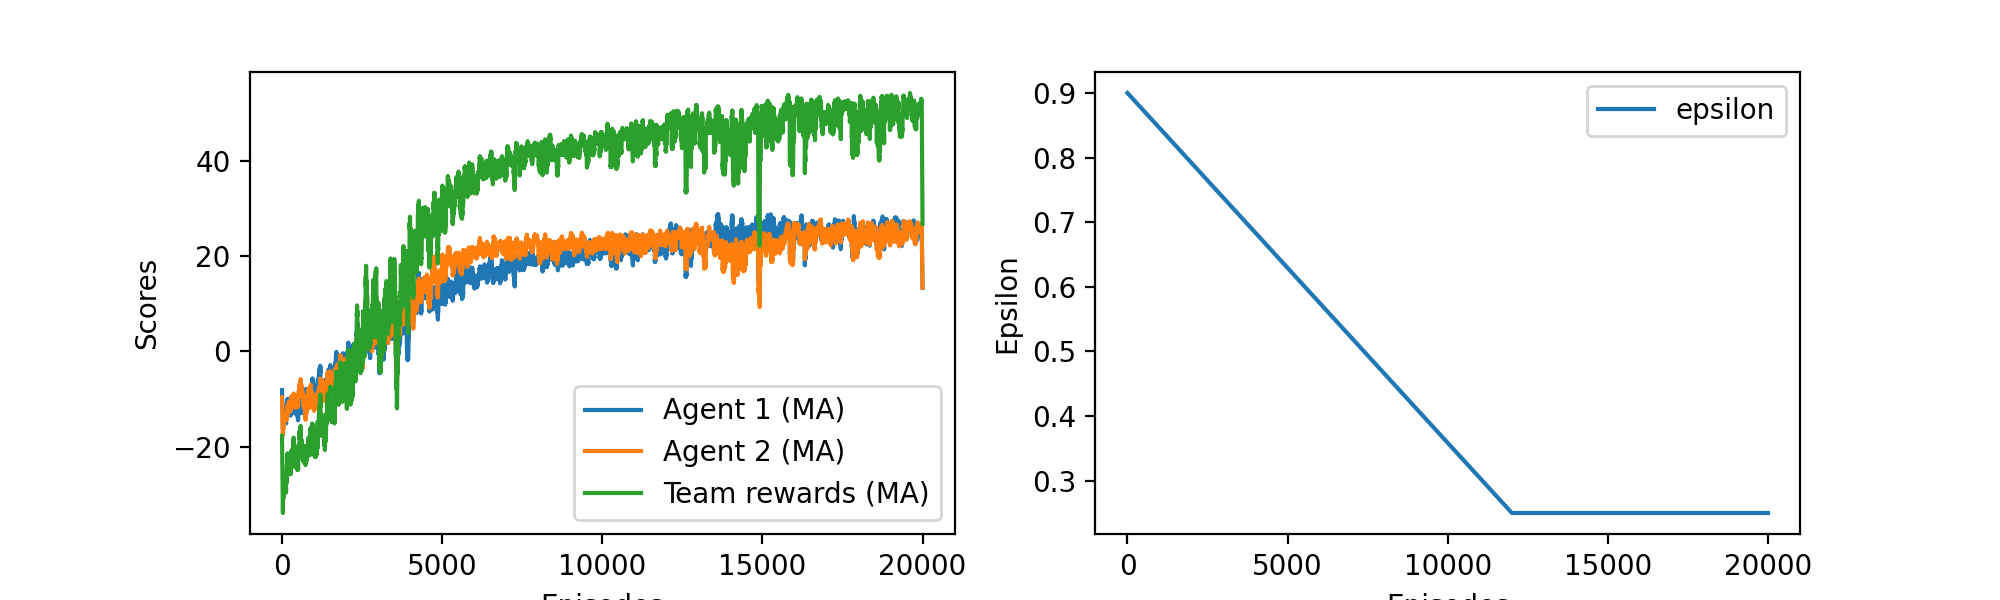

In [44]:
plot_scores_epsilon(reward_history, epsilon_history, moving_avg_window = 50)

## Visualise agent behaviour

In [84]:
def visualise_VDN(agent, n_episodes, epsilon):

    # create env.
    env = Food_Collector_Env(grid_size=[11,11], n_agents=2)
    
    # create network -> agent already specified

    for episode_i in range(n_episodes):
        state = env.reset()
        done = [False for _ in range(env.n_agents)]
        with torch.no_grad():
            hidden = agent.init_hidden()
            step_counter = 0
            while not all(done):
                step_counter += 1
                action, hidden = agent.sample_action(torch.Tensor(state).unsqueeze(0), hidden, epsilon)
                action = action[0].data.cpu().numpy().tolist()
                next_state, reward, done, info = env.step(action)
                state = next_state
                
                env.render(frame_speed=0.01)
                
                if step_counter > 7:
                    break
    env.close()

<IPython.core.display.Javascript object>


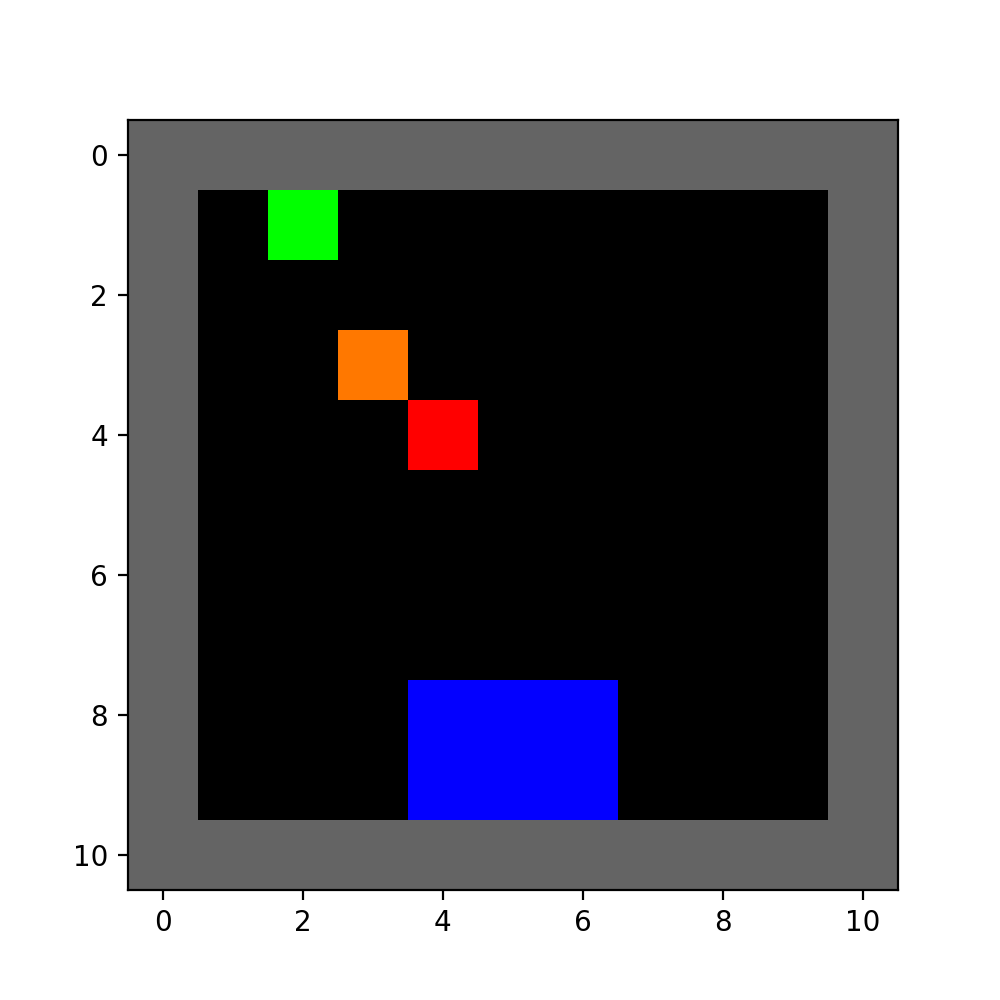

In [101]:
visualise_VDN(VDNagent, 1, 0)

## Save agent

In [49]:
# Save the agent
dill.dump(VDNagent, file = open("trained_agents/VDNagent.pickle", "wb"))

In [68]:
# Load agent
VDNagent = dill.load(open("trained_agents/VDNagent.pickle", "rb"))